In [1]:
import os
if "otgnn" not in os.getcwd():
    os.chdir("..")
    
import sys
sys.path.append(os.path.join(os.getcwd(), "iclr19-graph2graph", "props"))
sys.path.append(os.path.join(os.getcwd(), "otgnn"))

import importlib  
props = importlib.import_module("iclr19-graph2graph.props")

import numpy as np
import torch
# device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

from otgnn.utils import load_model
from otgnn.models import GCN, compute_ot
from otgnn.datasets import PropDataset
from otgnn.graph import MolGraph

from multiprocessing import Pool

import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('dark_background')

import seaborn as sns
sns.set_theme(style="whitegrid")
import pandas as pd

In [3]:
# load dataset
# dataset = PropDataset("data/sol/", data_type = "train")
dataset = PropDataset("iclr19-graph2graph/data/qed", data_type = "wengong")
path = "/home/octav/gitrepos/tum-thesis/images/"

iclr19-graph2graph/data/qed   wengong ; split= 0  num total=  88306  num pos= 0


In [4]:
# get molecular graphs for all molecules
# this takes a while
with Pool(24) as p:
    mol_graphs = p.map(MolGraph, dataset)

In [5]:
mol_graphs_lens = [(len(dp.mols[0].atoms), len(dp.mols[1].atoms)) for dp in mol_graphs]
mol_graphs_same = [x for i, x in enumerate(mol_graphs) if mol_graphs_lens[i][0] == mol_graphs_lens[i][1]]
len(mol_graphs_same), len(mol_graphs)

(5975, 88306)

# Get diagnostic stats about number of molecules

In [6]:
len_x = [x for (x, _) in mol_graphs_lens]
len_y = [y for (_, y) in mol_graphs_lens]

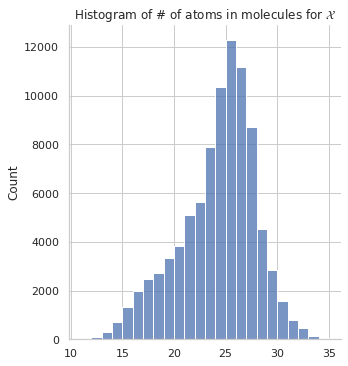

In [7]:
# plt.hist(len_x, bins = 20)
sns.displot(len_x,binwidth=1)
plt.title("Histogram of # of atoms in molecules for $\mathcal{X}$")
plt.savefig(path + "num_hist.png")

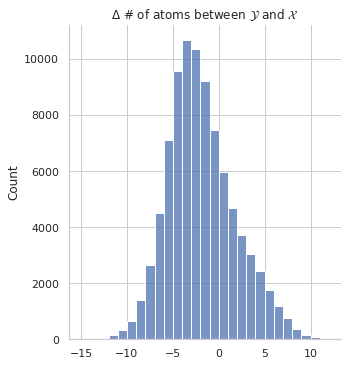

In [8]:
# plt.hist([y-x for (x, y) in mol_graphs_lens])
sns.displot([y-x for (x, y) in mol_graphs_lens], binwidth = 1)
plt.title("$\Delta$ # of atoms between $\mathcal{Y}$ and $\mathcal{X}$")
plt.savefig(path + "delta_hist.png")

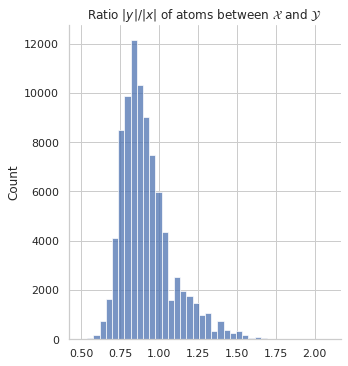

In [9]:
# plt.hist([y/x for (x, y) in mol_graphs_lens], bins = 40)
sns.displot([y/x for (x, y) in mol_graphs_lens], bins = 40)
plt.title("Ratio $|y|/|x|$ of atoms between $\mathcal{X}$ and $\mathcal{Y}$")
plt.savefig(path + "ratio_hist.png")

# More stats

In [10]:
len(mol_graphs)

88306

In [11]:
x = mol_graphs[0].mols[1]

In [12]:
x.bonds[0].bond_type

rdkit.Chem.rdchem.BondType(1)

Text(0.5, 1.0, 'Distribution of Atom Types (Pct)')

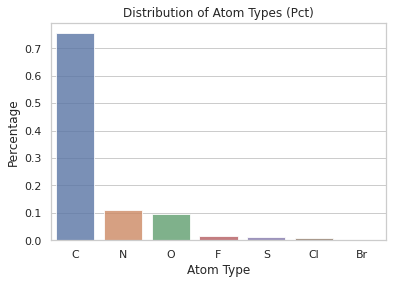

In [13]:
symbols = [x.symbol for y in mol_graphs for x in y.mols[1].atoms]
symb_counts = pd.Series(symbols).value_counts().reset_index()
symb_counts[0] = symb_counts[0]/symb_counts[0].sum()

g = sns.barplot(y = 0, x = "index", data = symb_counts, ci="sd", alpha = 0.8)
# g.despine(left=True)
g.set_xlabel("Atom Type")
g.set_ylabel("Percentage")
g.set_title("Distribution of Atom Types (Pct)")

In [14]:
g.hlines

<bound method Axes.hlines of <AxesSubplot:title={'center':'Distribution of Atom Types (Pct)'}, xlabel='Atom Type', ylabel='Percentage'>>

<AxesSubplot:xlabel='index', ylabel='0'>

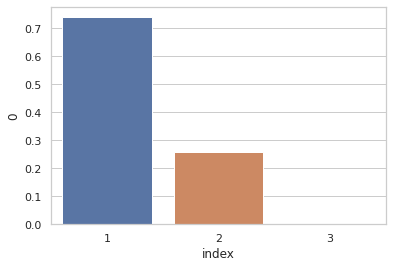

In [15]:
bonds = [x.bond_type for y in mol_graphs for x in y.mols[1].bonds]
bond_counts = pd.Series(bonds).value_counts().reset_index()
bond_counts[0] = bond_counts[0]/bond_counts[0].sum()
sns.barplot(y = 0, x = "index", data = bond_counts)

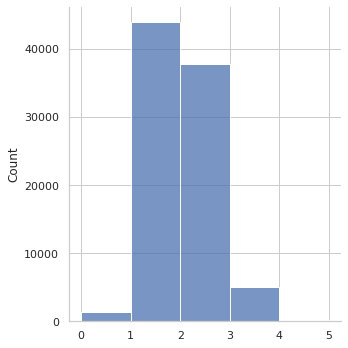

In [16]:
# euler error
sns.displot([len(x.mols[1].bonds)/2 - len(x.mols[1].atoms) for x in mol_graphs], binwidth = 1)

# Complex stats

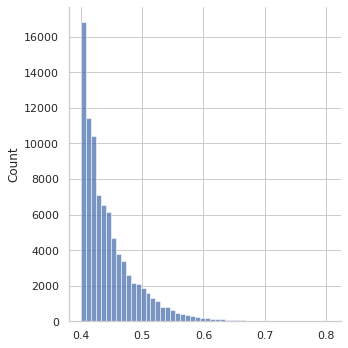

In [33]:
def fc(x):
    return props.similarity(*x)
with Pool(24) as p:
    simils = p.map(fc, dataset)
    
sns.displot(simils, bins = 50)

# Visualize

In [17]:
import rdkit.Chem as Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

In [18]:
ds_sample = dataset.data[0:5]

In [19]:
mol_list = [(Chem.MolFromSmiles(x), Chem.MolFromSmiles(y)) for (x,y) in ds_sample]

In [20]:
rdDepictor.Compute2DCoords(mol_list[0][0])

0

In [21]:
x = mol_list[0][0]

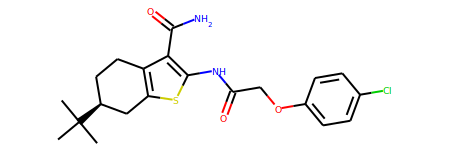

In [22]:
display(x)

In [38]:
for i in range(3):
    for j in range(2):
        Chem.Draw.MolToFile(mol_list[i][j],path + 'mol_exp_{}_{}.png'.format(i, j))  